# TPE N°2 : Les expérimentations sur la fonction de Rossenbrock

## Noms et Matricules des membres


| MATRICULES  |           NOMS DES MEMBRES           |
|-------------|--------------------------------------|
|   22T2960   |           BELL ARSÈNE KEVIN          |
|   22W2147   |           MELONG LETHYCIA            |
|   22W2164   |       DASSI MANDJO LEA JUSTINE       |

Notre étude portera tout le long sur la Fonction de Rossenbrock   $f(x, y) = (1 - x)² + 100(y - x²)²$

Nous implémenterons la méthode de plus profonde descente pour minimiser cette fonction et par la suite, nous analyserons des résultats obtenus.

In [1]:
import sympy as sp
import numpy as np
from scipy.optimize import minimize_scalar
import pandas as pd



x, y = sp.symbols("x y")
# Fonction de Rosenbrock
f = (1 - x)**2 + 100 * (y - x**2)**2
grad_f = sp.Matrix([sp.diff(f, x), sp.diff(f, y)])

points_critiques = sp.solve(grad_f,(x, y))   # Points criiques de h
print(f"Points critiques de la fonction = {points_critiques}")

print("\nMatrice hessienne de la fonction de Rossenbrock")
h = sp.hessian(f, [x, y])
sp.pprint(h)

Points critiques de la fonction = [(1, 1)]

Matrice hessienne de la fonction de Rossenbrock
⎡      2                    ⎤
⎢1200⋅x  - 400⋅y + 2  -400⋅x⎥
⎢                           ⎥
⎣      -400⋅x          200  ⎦


Apres avoir determiner la nature de l'unique point fixe de la fonction on remarque le point (1, 1) est un minimum local.
Etant donné que notre fonction est deux fois derivable et sa deuxieme derivée est continue, on peut affirmer que la fonction est convexe,
Donc le point (1, 1) est le seul point de minimum global de la fonction  $f(x, y) = (1 - x)² + 100(y - x²)²$

## Descente du gradient pas fixe

In [2]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
    
f_num = sp.lambdify((x, y), f, "numpy")

def rosenbrock_grad(x):
    dx = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
    dy = 200 * (x[1] - x[0]**2)
    return np.array([dx, dy])

grad_num = sp.lambdify((x, y), grad_f, "numpy")




def gradient(f, symboles):
    return sp.Matrix([ f.diff(s) for s in symboles ])

def grad(f, X):
    x, y = sp.symbols("x y")
    gf = gradient(f, [x, y])

    result = []
    for g in gf:
        df = g.subs([(x, X[0]), (y, X[1])])
        result.append(df)
    return sp.Matrix(result)

def is_inf(A, r):
    return all(a < r for a in A)

def descente_pas_fixe(f, grad, x0, s, eps, max_iter):
    k = 0
    xk = sp.Matrix(x0)
    path = [xk.copy()] # Historique des positions
    iterations = []
    
    print(" ---------------------------------------Descente de gradient pas fixe--------------------------------------------")
    while k < max_iter :
        g = -1 * grad(f, xk)
        xk_1 = xk + s*g

        # Bloc utile pour le graphique de la descente
        fx = f_num(xk[0], xk[1])
        g = np.array(grad_num(xk[0], xk[1])).flatten()
        norm2g = np.dot(g, g)

        iterations.append([
            fx,                  # f(xk, yk)
            norm2g,              # norme du gradient au carré
            s,               # pas α
            xk[0],               # xk
            xk[1]                # yk
        ])

        df = pd.DataFrame(iterations, columns=[
         "f(xk,yk)", "||Vf(xk, yk)|| ", "Pas", "xk", "yk"
        ])
        # Fin du bloc

        if is_inf(abs(xk_1 - xk), eps):
            print(df)
            return xk
        k += 1
        
        
        xk = xk_1
        path.append(xk.copy())
    print(df)
    return np.array(path)


start_point = [-1.5, 1.5] # Point de départ intéressant pour voir la courbe
max_iter = 1000
eps = 0.0001
symbols = (x, y)

path_pas_fixe = descente_pas_fixe(f, grad, start_point, 0.0025, eps, max_iter)


 ---------------------------------------Descente de gradient pas fixe--------------------------------------------
               f(xk,yk)     ||Vf(xk, yk)||      Pas                  xk  \
0      62.5000000000000    229525.000000000  0.0025   -1.50000000000000   
1      305.868322753906    184152.822710571  0.0025  -0.362500000000000   
2      4.02713471205156    78.2715589822930  0.0025  -0.987740234375000   
3      4.06293554918407    168.982233289564  0.0025   -1.00503585699731   
4      4.15401000343211    351.756269639653  0.0025  -0.974226409506128   
..                  ...                 ...     ...                 ...   
995  0.0346023103888334  0.0378297035341095  0.0025   0.814168040716335   
996  0.0345078114304161  0.0377093323871988  0.0025   0.814421915494561   
997  0.0344136131103051  0.0375894240264989  0.0025   0.814675328937673   
998  0.0343197142729027  0.0374699762665594  0.0025   0.814928282264005   
999  0.0342261137680668  0.0373509869345285  0.0025   0.81518

### Conclusion pour le pas fixe
Parametres utilisés :
- max_iter = 1000
- epsilon = 0.0001
- x0 = [-1.5, 1.5]

Les deux conditions d'arret uilisée etaient :
- Le nombre maximal d'iteration max_iter = 1000
- La distance des points $|(x_{k+1} - x_{k})| < eps$
  
L'algorithme arrive au nombre max d'iteration avec :
- $f(x_{k}, y_{k}) = 0.0342$
- $x_{k} = 0.8151$ et $y_{k} = 0.6636$

## Descente du gradient pas optimal

In [3]:
# 2. Évaluation numérique du gradient
def eval_grad(grad_sym, symbols, X_val):
    substitutions = [(symbols[0], X_val[0]), (symbols[1], X_val[1])]
    
    grad_val = grad_sym.subs(substitutions)
    return np.array(grad_val).astype(np.float64).flatten()

# 3. Fonction objectif pour la recherche linéaire (
def func_objective_for_step(s, f, symbols, xk, direction):
    # direction = -grad
    next_x = xk[0] + s * direction[0]
    next_y = xk[1] + s * direction[1]

    val = f.subs([(symbols[0], next_x), (symbols[1], next_y)])
    return float(val) # Important : retourner un float Python pur

def descente_pas_optimal(f, symbols, x0, eps, max_iter):
    xk = np.array(x0, dtype=float)    
    path = [xk.copy()] # Historique des positions

    print(" ---------------------------------------Descente de gradient pas optimal-----------------------------------------")
    grad_sym = gradient(f, symbols)    
    print(f"Départ : {xk}")

    iterations = []
    
    for k in range(max_iter):
        g_val = eval_grad(grad_sym, symbols, xk)
        
        # Condition d'arrêt 
        if np.linalg.norm(g_val) < eps:
            print(f"Convergence atteinte à l'itération {k}")
            return xk

        direction = -g_val
        
        # C. Recherche du pas optimal 's', On définit une fonction lambda qui ne dépend QUE de s
        line_obj = lambda s: func_objective_for_step(s, f, symbols, xk, direction)
        
        # On cherche s entre 0 et 1
        res = minimize_scalar(line_obj, method='brent') 
        s_opt = res.x        
        xk_new = xk + s_opt * direction 
        path.append(xk_new.copy())

        # Bloc utile pour le graphique de la descente
        fx = f_num(xk[0], xk[1])
        g = np.array(grad_num(xk[0], xk[1])).flatten()
        norm2g = np.dot(g, g)        
        iterations.append([
            fx,                  # f(xk, yk)
            norm2g,              # norme du gradient au carré
            s_opt,               # pas α
            xk[0],               # xk
            xk[1]                # yk
        ])

        df = pd.DataFrame(iterations, columns=[
         "f(xk,yk)", "||Vf(xk, yk)|| ", "Pas", "xk", "yk"
        ])
        # Fin du bloc
        
        xk = xk_new
    print(df)
        
    return np.array(path)

path = descente_pas_optimal(f, symbols, start_point, eps, max_iter)

 ---------------------------------------Descente de gradient pas optimal-----------------------------------------
Départ : [-1.5  1.5]
      f(xk,yk)  ||Vf(xk, yk)||        Pas        xk        yk
0    62.500000    229525.000000  0.000540 -1.500000  1.500000
1     5.087842         2.797693  0.131584 -1.254226  1.581025
2     4.884346       443.704635  0.000765 -1.185316  1.371999
3     4.715540         2.930013  0.088337 -1.170008  1.377046
4     4.578265       296.079016  0.000841 -1.122665  1.233439
..         ...              ...       ...       ...       ...
995   0.082340         0.072391  0.001622  1.286664  1.656783
996   0.082281         0.106767  0.001099  1.286801  1.656369
997   0.082222         0.072315  0.001622  1.286460  1.656256
998   0.082164         0.106631  0.001100  1.286597  1.655842
999   0.082105         0.072238  0.001623  1.286255  1.655729

[1000 rows x 5 columns]


### Conclusion pour le pas optimal
Parametres utilisés :
- max_iter = 1000
- epsilon = 0.0001
- x0 = [-1.5, 1.5]

Les deux conditions d'arret uilisée etaient :
- Le nombre maximal d'iteration max_iter = 1000
- La Valeur du gradient $|\nabla(f(x_{k}))| < eps$
  
L'algorithme arrive au nombre max d'iteration avec :
- $f(x_{k}, y_{k}) = 0.0821$
- $x_{k} = 1.2862$ et $y_{k} = 1.6557$

## Representation graphique des deux descentes

Nombre d'itérations : 1001
Point final pas fixe : [[0.815432813416673]
 [0.664107483742161]]


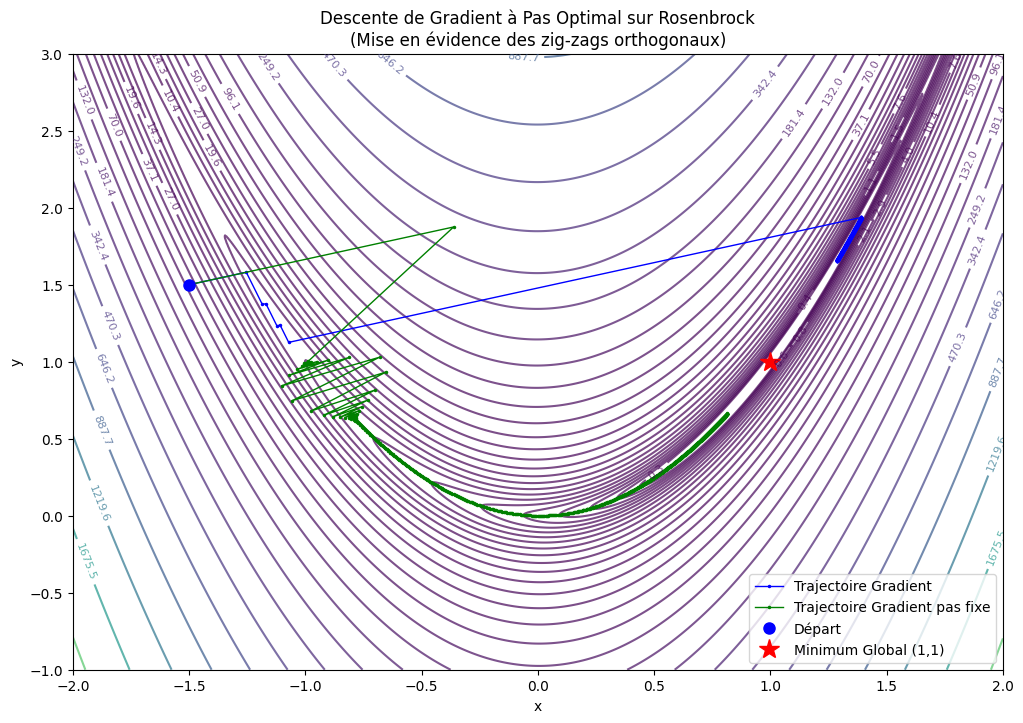

In [4]:
import matplotlib.pyplot as plt

# --- 3. Génération des données ---

print(f"Nombre d'itérations : {len(path)}")
print(f"Point final pas fixe : {path_pas_fixe[-1]}")

# --- 4. Visualisation ---
plt.figure(figsize=(12, 8))

# A. Création du fond (Contours)
x_grid = np.linspace(-2, 2, 600)
y_grid = np.linspace(-1, 3, 600)
X, Y = np.meshgrid(x_grid, y_grid)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Échelle logarithmique pour les niveaux (essentiel pour Rosenbrock)
levels = np.logspace(-0.5, 3.5, 30)
contour = plt.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.7)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

# B. Tracé de la trajectoire
# On trace la ligne en blanc pour le contraste
plt.plot(path[:, 0], path[:, 1], 'b.-', linewidth=1, markersize=3, label='Trajectoire Gradient')
plt.plot(path_pas_fixe[:, 0], path_pas_fixe[:, 1], 'g.-', linewidth=1, markersize=3, label='Trajectoire Gradient pas fixe')

# C. Marquage des points clés
plt.plot(start_point[0], start_point[1], 'bo', markersize=8, label='Départ')
plt.plot(1, 1, 'r*', markersize=15, label='Minimum Global (1,1)')

# Zoomer un peu sur la zone d'intérêt si besoin
# plt.xlim(-1.6, 1.2)
# plt.ylim(-0.5, 2.0)

plt.title("Descente de Gradient à Pas Optimal sur Rosenbrock\n(Mise en évidence des zig-zags orthogonaux)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

## Conclusion generale

On constate que la descente avec le pas fixe semble converger plus vite que celle du pas optimal.

On a les données suivantes pour les deux descentes :
- **Pour le pas fixe**
- $f(x_{k}, y_{k}) = 0.0342$
- $x_{k} = 0.8151$ et $y_{k} = 0.6636$
- **Pour le pas optimal**
- $f(x_{k}, y_{k}) = 0.0821$
- $x_{k} = 1.2862$ et $y_{k} = 1.6557$

### Explication : 

La raison principale pour laquelle le **pas fixe** pourrait sembler converger plus vite est que la méthode du **pas optimal** est très lente sur les fonctions avec des vallées étroites et courbées, comme celle de Rosenbrock.

Dans la vallée étroite de **Rosenbrock**, la direction de descente est presque perpendiculaire aux lignes de niveau. Le pas optimal garantit que le nouveau point est trouvé là où le gradient est orthogonal à la direction de descente précédente:
- Ceci force l'algorithme à faire de petits pas successifs en zig-zag d'un bord à l'autre de la vallée, sans jamais progresser efficacement le long du fond de la vallée vers le minimum global.
- Chaque itération est très efficace (parce que le pas est optimal), mais la direction prise est très mauvaise.